In [3]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [4]:
import numpy as np
#----------------------------------------------------------------------
# Densidad superficial de masa con bines equiespaciados (en x o y)
#----------------------------------------------------------------------
def surf_density_x(x,y,m,nbin,nmin,nmax):
    
    
    mass, xedges, yedges = np.histogram2d(x, y, nbin, [[nmin,nmax],[nmin,nmax]], density=False, weights=m)
    
#     nodos  = np.concatenate([-nodos_[::-1],nodos_])
    
    sigmax = np.zeros(nbin)
    sigmay = np.zeros(nbin)
    
    widthx = np.diff(xedges)
    widthy = np.diff(yedges)
    
    medx   = xedges[:-1] + widthx/2.
    medy   = yedges[:-1] + widthy/2.
    
    middle = nbin//2
    
    for i in range(nbin):
        areax     = widthx[i]*widthy[middle]
        sigmax[i] = mass[i,middle]/areax

        areay     = widthy[i]*widthx[middle]
        sigmay[i] = mass[middle,i]/areay
    
    return sigmax, sigmay, medx, medy

### Perfiles para Gadget

lbar_perf = 2.347136114565877
lbar_perf_mod =  1.6947925361804372
lbar_perf = 1.9162435234042356
lbar_perf_mod =  1.7693979768996755
lbar_perf = 0.17609125905568135
lbar_perf_mod =  0.17609125905568135


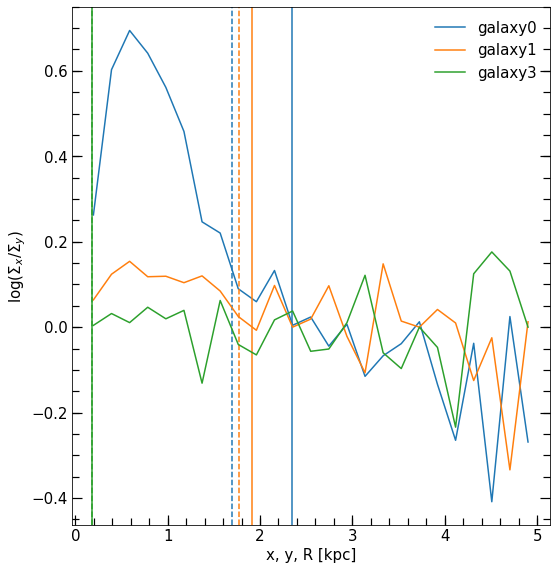

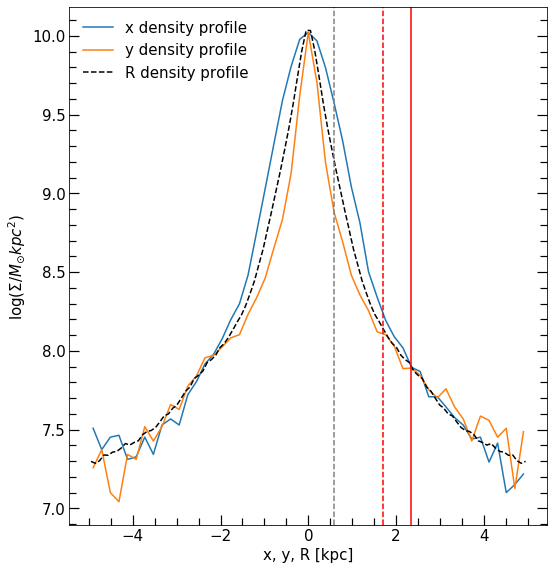

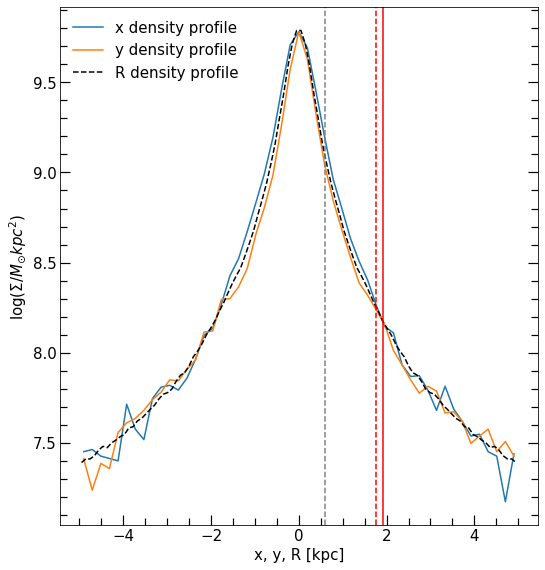

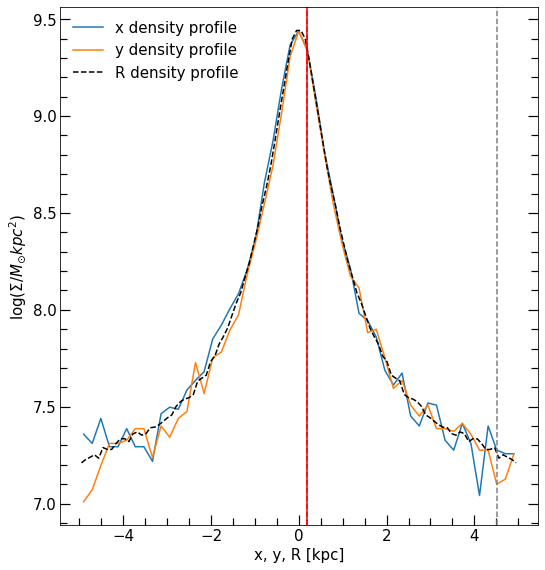

In [5]:
import h5py
import rotation_mio as rot
import time_conversion as tiempo
import barstrength2 as strng
import scipy.interpolate as sint
import numpy as np
import matplotlib.pyplot as plt
import density

#Parámetros cosmológicos
#--------------------------------------------------------------------------
h=0.732
G = 4.299e-6
a0=1.
H0 = h*100
omega_lambda=0.716
omega_matter=0.1277/(h**2.)
omega0 = omega_lambda + omega_matter
#---------------------------------------------------------------------------

path0 = '/home/omarioni/'
aa = np.loadtxt(path0 + 'redshift_outputs.txt')
aexp = aa[:,2]

# snapshot=range(496,300,-1) #SNAPSHOTS

path = '/mnt/is2/alejandro/ornella/'

colores = ('r','b','white','g')
colores = ('A-Gadget2','B-Gadget2','white','C-Gadget2')
figs, axs = plt.subplots(nrows=1, ncols=1, figsize=(8,8))
figs.subplots_adjust(bottom=0.06, left =0.1, right = 0.93, top = 0.96, wspace=0., hspace= 0.)


# for isnap in snapshot:

isnap=496

halos = (0,1,3)

for i in halos:
# i=0
    snap = h5py.File(path + 'outputs_1/snap_'+str('%03d'%isnap)+'.h5py', 'r')

    cm   = snap['subhalo_00'+str('%s'%i)+'/Center'][()]
    r200 = snap['subhalo_00'+str('%s'%i)+'/R200'][()]

    pstr = snap['subhalo_00'+str('%s'%i)+'/Str/Coordinates'][()]
    mstr = snap['subhalo_00'+str('%s'%i)+'/Str/Masses'][()]
    vel  = snap['subhalo_00'+str('%s'%i)+'/Str/Velocities'][()]

    z     = a0/aexp[isnap] - 1.
    Ht    = H0*np.sqrt(omega_lambda+(1-omega0)*(1+z)**2+omega_matter*(1+z)**3)
    time  = tiempo.conv(z, h, omega_lambda, omega_matter)

    #paso las coordenadas al centro de la galaxia y paso a coordenadas físicas
    xstr = (pstr[:,0]-cm[0])*aexp[isnap]/h
    ystr = (pstr[:,1]-cm[1])*aexp[isnap]/h
    zstr = (pstr[:,2]-cm[2])*aexp[isnap]/h
    r    = np.sqrt(xstr**2+ystr**2+zstr**2)

    #paso las velocidades a unidades físicas
    v_x = vel[:,0] *np.sqrt(aexp[isnap]) + Ht *xstr/1000.
    v_y = vel[:,1] *np.sqrt(aexp[isnap]) + Ht *ystr/1000.
    v_z = vel[:,2] *np.sqrt(aexp[isnap]) + Ht *zstr/1000.

    mstr = mstr/h     #masa a unidades físicas

    r200 = r200*aexp[isnap]/h #radio virial a unidades fisicas

    rgal = 0.15*r200          #defino el radio de la galaxia

    limit = np.where(r<rgal)         #hago un límite de los r dentro de rgal
    r_sort = np.sort(r[limit])       #acomodo los r de menor a mayor
    r_indice = np.argsort(r[limit])  #saco los argumentos de r acomodados de menor a mayor

    Mc_str = np.cumsum(mstr[limit][r_indice])  #masa acumulada en cada radio dentro de rgal
    Mgal = Mc_str[-1]  #masa total de la galaxia

    #Calculo de los radios a 50% y 90% la masa de la galaxia
    #-----------------------------------------------------------------------
    razon = Mc_str/Mgal 
    noventa, = np.where(razon < 0.9)
    cincuenta, = np.where(razon < 0.5)

    r90 = r_sort[noventa][-1]   #radio a 90% la masa
    r50 = r_sort[cincuenta][-1] #radio a 50% la masa

    #componentes de la velocidad del centro de masa
    veloc, = np.where(r < r50)

    vxcm = sum(mstr[veloc]*v_x[veloc])/sum(mstr[veloc])
    vycm = sum(mstr[veloc]*v_y[veloc])/sum(mstr[veloc])
    vzcm = sum(mstr[veloc]*v_z[veloc])/sum(mstr[veloc])

    #velocidades de las estrellas respecto del centro de masa de la galaxia
    vx = v_x - vxcm
    vy = v_y - vycm
    vz = v_z - vzcm

    #-------------------------------------------------------------------------------------
    #hago la rotación de las coordenadas respecto del momento angular    
    e1x,e2x,e3x,e1y,e2y,e3y,e1z,e2z,e3z = rot.rot1(mstr,xstr,ystr,zstr,vx,vy,vz,3*aexp[isnap])

    xn = e1x*xstr + e1y*ystr + e1z*zstr
    yn = e2x*xstr + e2y*ystr + e2z*zstr
    zn = e3x*xstr + e3y*ystr + e3z*zstr
    vxn = e1x*vx + e1y*vy + e1z*vz
    vyn = e2x*vx + e2y*vy + e2z*vz
    vzn = e3x*vx + e3y*vy + e3z*vz

    corte, = np.where(r < 6.)

    A2max, rmax, phimax, phimed = strng.a2max(mstr[corte], xn[corte], yn[corte], 20)

    xx = xn*np.cos(phimed)  + yn*np.sin(phimed)
    yy = xn*-np.sin(phimed) + yn*np.cos(phimed)
    zz = zn

    R = np.sqrt(xx**2 + yy**2)

    corte, = np.where(r<rgal)

    nbin = 51
    #     x_profile, medx = surf_density_x(xx[corte],yy[corte],mstr[corte]*1e10,51,-5,5)    
    #     y_profile, medy = surf_density_x(yy[corte],xx[corte],mstr[corte]*1e10,51,-5,5)
    R_profile, medR = density.surf_density2(R[corte], mstr[corte]*1e10,nbin,0,5)

    #     R_profile = (x_profile + y_profile)/2

    sigmax, sigmay, medx, medy = surf_density_x(xx[corte],yy[corte],mstr[corte]*1e10,nbin,-5,5)

    # print sigmax, sigmay

    #-------lbar---------------------------------------------------------------
    diff = np.log10(sigmax[np.where(medx>0)]) - np.log10(sigmay[np.where(medx>0)])

    # print diff.max(), diff.argmax()
    arg = diff.argmax()
    # print medx[np.where(medx>0)][arg]

    cut = diff.max()*5./100.

    finterp = sint.interp1d(medx[np.where(medx>0)],diff,fill_value="extrapolate")
    point = np.linspace(diff.max(),5,100)

    resta = finterp(point) - cut
    mask, = np.where(resta < 0.)

    lbar4 = point[mask][0]

    print 'lbar_perf =', lbar4

    cut2 = diff.max()*20./100.

    resta2 = finterp(point) - cut2
    mask2, = np.where(resta2 < 0.)

    lbar6 = point[mask2][0]

    print 'lbar_perf_mod = ', lbar6

    RR  = np.concatenate([-medR[::-1],medR])
    Rpf = np.concatenate([R_profile[::-1],R_profile])
    
#     vector=('M31','MW','..','M33')
#     path2 = '/home/omarioni/Barras_GdGs/Barras_Gd/_data/correcciones/'
#     archivo = np.ndarray
#     np.savetxt(archivo,'')
    
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,8))
    fig.subplots_adjust(bottom=0.06, left =0.1, right = 0.93, top = 0.96, wspace=0., hspace= 0.)
    ax.plot(medx, np.log10(sigmax), '-',color='tab:blue', label='x density profile')    
    ax.plot(medy, np.log10(sigmay), '-',color='tab:orange', label='y density profile')    
    ax.plot(RR, np.log10(Rpf), color='k', ls='--', label='R density profile')
    #     ax.plot(medx, diff)
    ax.axvline(x=lbar4,color='r')
    ax.axvline(x=lbar6,color='r',ls='--')
    ax.axvline(x=medx[np.where(medx>0)][arg], color='gray',ls='--')
    # ax.plot(-medR, np.log10(R_profile),color='k', ls='--')
    ax.minorticks_on()
    ax.tick_params( labelsize=15)
    ax.tick_params('both', length=7, width=1.2,which='minor', direction='in', right=True,top=False)
    ax.tick_params('both', length=10, width=1.2,which='major', direction='in', right=True,top=False)
    ax.set_ylabel('log($\Sigma$/$M_{\odot}kpc^2$)',fontsize=15)
    ax.set_xlabel('x, y, R [kpc]',fontsize=15)
    ax.legend(fontsize=15,frameon=False)
    
    

    axs.plot(medx[np.where(medx>0)], diff, '-', label=str('%s'%galaxy[i]))
    axs.axvline(x=lbar4,ls='-',color=colores[i])
    axs.axvline(x=lbar6,ls='--',color=colores[i])


axs.minorticks_on()
axs.tick_params( labelsize=15)
axs.tick_params('both', length=7, width=1.2,which='minor', direction='in', right=True,top=False)
axs.tick_params('both', length=10, width=1.2,which='major', direction='in', right=True,top=False)
axs.set_ylabel('log($\Sigma_x / \Sigma_y$)',fontsize=15)
axs.set_xlabel('x, y, R [kpc]',fontsize=15)
axs.legend(fontsize=15,frameon=False)

plt.show()

path = '/home/omarioni/Barras_GdGs/Barras_Gd/_imagenes/'

# fig.savefig('density_profilesXY_GD.pdf', dpi = 100, xxbox_inches='tight')
# figs.savefig('density_difference_GD.pdf', dpi = 100, xxbox_inches='tight')

### Perfiles para Gasoline

lbar_perf = 1.2056250173727554
lbar_perf_mod =  1.035091310288385
lbar_perf = 3.1176338480025576
lbar_perf_mod =  1.8627230800042627
lbar_perf = 0.7873607639610815
lbar_perf_mod =  0.20630707623157551


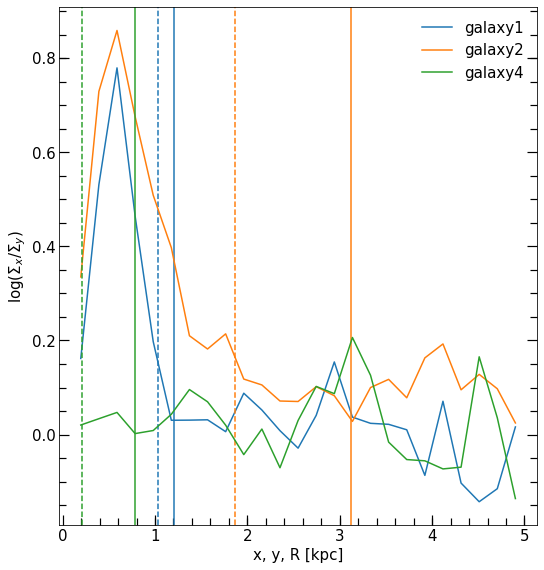

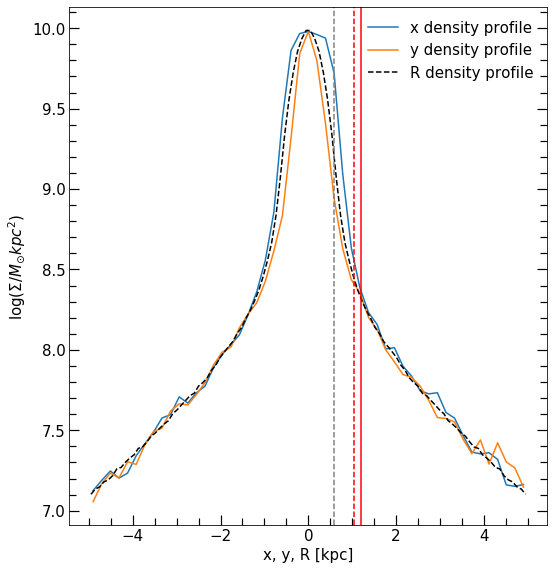

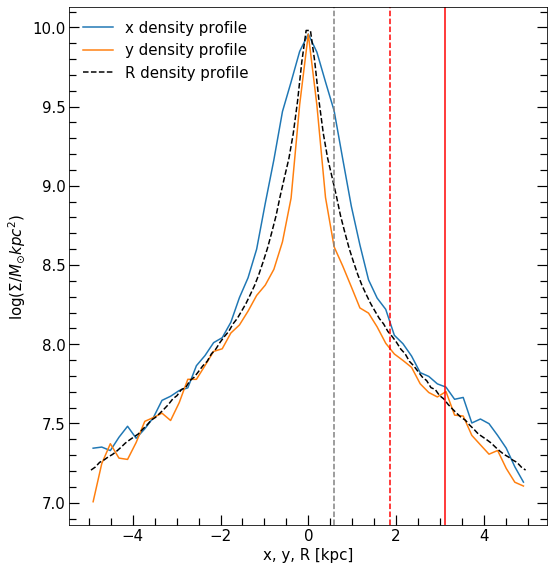

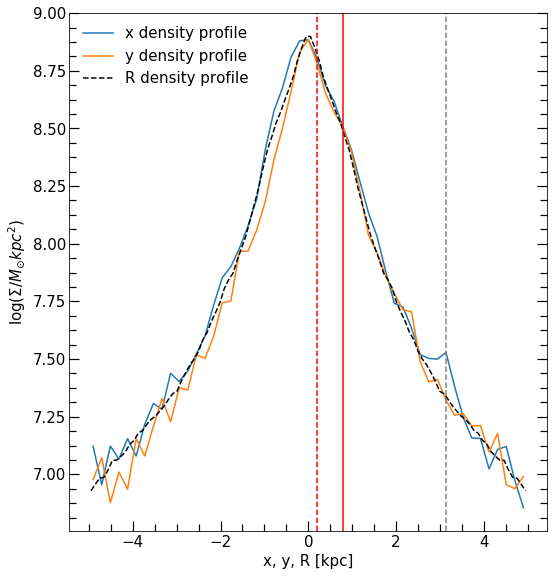

In [76]:
import h5py
import rotation_mio as rot
import time_conversion as tiempo
import barstrength2 as strng
import scipy.interpolate as sint
import numpy as np
import matplotlib.pyplot as plt
import density

#Parámetros cosmológicos
#--------------------------------------------------------------------------
G = 4.299e-6
a0=1.
#---------------------------------------------------------------------------

# path = '/home/ornela/SimCLUES/'
path = '/mnt/sersic2/omarioni/'

snapshot = np.loadtxt(path + 'Gasoline/snapshots.txt', dtype='string')
snapshot = snapshot[::-1]

colores = ('r','tab:blue','tab:orange','r','tab:green')
figs, axs = plt.subplots(nrows=1, ncols=1, figsize=(8,8))
figs.subplots_adjust(bottom=0.06, left =0.1, right = 0.93, top = 0.96, wspace=0., hspace= 0.)

# for j in range(len(snapshot)-1,32,-1):
j=0

halos = (1,2,4)

for i in halos:
# i=1
    snap = h5py.File(path + 'Gasoline/outputs2/snap_'+str('%s'%snapshot[j])+'.h5py', 'r')

    cm   = snap['subhalo_00'+str('%s'%i)+'/Center'][()]
    r200 = snap['subhalo_00'+str('%s'%i)+'/R200'][()]
    time = snap['subhalo_00'+str('%s'%i)+'/Time'][()]
    h    = snap['subhalo_00'+str('%s'%i)+'/h'][()]
    aexp = snap['subhalo_00'+str('%s'%i)+'/aexp'][()]

    pstr = snap['subhalo_00'+str('%s'%i)+'/Str/Coordinates'][()]
    mstr = snap['subhalo_00'+str('%s'%i)+'/Str/Masses'][()]
    vel  = snap['subhalo_00'+str('%s'%i)+'/Str/Velocities'][()]

    #paso las coordenadas al centro de la galaxia
    xstr = (pstr[:,0]-cm[0])
    ystr = (pstr[:,1]-cm[1])
    zstr = (pstr[:,2]-cm[2])
    r    = np.sqrt(xstr**2+ystr**2+zstr**2)
    #----------------------------------------------------------------------
    r200 = r200*aexp
    rgal = 0.15*r200          #defino el radio de la galaxia

    limit = np.where(r<rgal)         #hago un límite de los r dentro de rgal
    r_sort = np.sort(r[limit])       #acomodo los r de menor a mayor
    r_indice = np.argsort(r[limit])  #saco los argumentos de r acomodados de menor a mayor

    Mc_str = np.cumsum(mstr[limit][r_indice])  #masa acumulada en cada radio dentro de rgal
    Mgal = Mc_str[-1]  #masa total de la galaxia

    #Calculo de los radios a 50% y 90% la masa de la galaxia
    #-----------------------------------------------------------------------
    razon = Mc_str/Mgal 
    noventa, = np.where(razon < 0.9)
    cincuenta, = np.where(razon < 0.5)

    r90 = r_sort[noventa][-1]   #radio a 90% la masa
    r50 = r_sort[cincuenta][-1] #radio a 50% la masa

    #-----------------------------------------------------------------------

    #componentes de la velocidad del centro de masa
    veloc, = np.where(r < r50)

    vxcm = sum(mstr[veloc]*vel[:,0][veloc])/sum(mstr[veloc])
    vycm = sum(mstr[veloc]*vel[:,1][veloc])/sum(mstr[veloc])
    vzcm = sum(mstr[veloc]*vel[:,2][veloc])/sum(mstr[veloc])

    #velocidades de las estrellas respecto del centro de masa de la galaxia
    vx = vel[:,0] - vxcm
    vy = vel[:,1] - vycm
    vz = vel[:,2] - vzcm

        #-----------------------------------------------------------------------------------

        #hago la rotación de las coordenadas respecto del momento angular    
    e1x,e2x,e3x,e1y,e2y,e3y,e1z,e2z,e3z = rot.rot1(mstr,xstr,ystr,zstr,vx,vy,vz,3*aexp)

    xn = e1x*xstr + e1y*ystr + e1z*zstr
    yn = e2x*xstr + e2y*ystr + e2z*zstr
    zn = e3x*xstr + e3y*ystr + e3z*zstr
    vxn = e1x*vx + e1y*vy + e1z*vz
    vyn = e2x*vx + e2y*vy + e2z*vz
    vzn = e3x*vx + e3y*vy + e3z*vz

    corte, = np.where(r < 6.)

    A2max, rmax, phimax, phimed = strng.a2max(mstr[corte], xn[corte], yn[corte], 20)

    xx = xn*np.cos(phimed)  + yn*np.sin(phimed)
    yy = xn*-np.sin(phimed) + yn*np.cos(phimed)
    zz = zn

    R = np.sqrt(xx**2 + yy**2)

    corte, = np.where(r<rgal)

    nbin = 51
    #     x_profile, medx = surf_density_x(xx[corte],yy[corte],mstr[corte]*1e10,51,-5,5)    
    #     y_profile, medy = surf_density_x(yy[corte],xx[corte],mstr[corte]*1e10,51,-5,5)
    R_profile, medR = density.surf_density2(R[corte], mstr[corte],nbin,0,5)

    #     R_profile = (x_profile + y_profile)/2

    sigmax, sigmay, medx, medy = surf_density_x(xx[corte],yy[corte],mstr[corte],nbin,-5,5)

    # print sigmax, sigmay

    #-------lbar---------------------------------------------------------------
    diff = np.log10(sigmax[np.where(medx>0)]) - np.log10(sigmay[np.where(medx>0)])

    # print diff.max(), diff.argmax()
    arg = diff.argmax()
    # print medx[np.where(medx>0)][arg]

    cut = diff.max()*5./100.

    finterp = sint.interp1d(medx[np.where(medx>0)],diff,fill_value="extrapolate")
    point = np.linspace(diff.max(),5,100)

    resta = finterp(point) - cut
    mask, = np.where(resta < 0.)

    lbar4 = point[mask][0]

    print 'lbar_perf =', lbar4

    cut2 = diff.max()*20./100.

    resta2 = finterp(point) - cut2
    mask2, = np.where(resta2 < 0.)

    lbar6 = point[mask2][0]

    print 'lbar_perf_mod = ', lbar6

    RR  = np.concatenate([-medR[::-1],medR])
    Rpf = np.concatenate([R_profile[::-1],R_profile])
    
#     vector=('M31','MW','..','M33')
#     path2 = '/home/omarioni/Barras_GdGs/Barras_Gd/_data/correcciones/'
#     archivo = np.ndarray
#     np.savetxt(archivo,'')
    
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,8))
    fig.subplots_adjust(bottom=0.06, left =0.1, right = 0.93, top = 0.96, wspace=0., hspace= 0.)
    ax.plot(medx, np.log10(sigmax), '-',color='tab:blue', label='x density profile')    
    ax.plot(medy, np.log10(sigmay), '-',color='tab:orange', label='y density profile')    
    ax.plot(RR, np.log10(Rpf), color='k', ls='--', label='R density profile')
    #     ax.plot(medx, diff)
    ax.axvline(x=lbar4,color='r')
    ax.axvline(x=lbar6,color='r',ls='--')
    ax.axvline(x=medx[np.where(medx>0)][arg], color='gray',ls='--')
    # ax.plot(-medR, np.log10(R_profile),color='k', ls='--')
    ax.minorticks_on()
    ax.tick_params( labelsize=15)
    ax.tick_params('both', length=7, width=1.2,which='minor', direction='in', right=True,top=False)
    ax.tick_params('both', length=10, width=1.2,which='major', direction='in', right=True,top=False)
    ax.set_ylabel('log($\Sigma$/$M_{\odot}kpc^2$)',fontsize=15)
    ax.set_xlabel('x, y, R [kpc]',fontsize=15)
    ax.legend(fontsize=15,frameon=False)


    axs.plot(medx[np.where(medx>0)], diff, '-', label='galaxy'+str('%s'%i))
    axs.axvline(x=lbar4,ls='-',color=colores[i])
    axs.axvline(x=lbar6,ls='--',color=colores[i])


axs.minorticks_on()
axs.tick_params( labelsize=15)
axs.tick_params('both', length=7, width=1.2,which='minor', direction='in', right=True,top=False)
axs.tick_params('both', length=10, width=1.2,which='major', direction='in', right=True,top=False)
axs.set_ylabel('log($\Sigma_x / \Sigma_y$)',fontsize=15)
axs.set_xlabel('x, y, R [kpc]',fontsize=15)
axs.legend(fontsize=15,frameon=False)

plt.show()

### Perfiles para Gadget

In [6]:
import h5py
import rotation_mio as rot
import time_conversion as tiempo
import barstrength2 as strng
import scipy.interpolate as sint
import numpy as np
import matplotlib.pyplot as plt
import density

#Parámetros cosmológicos
#--------------------------------------------------------------------------
h=0.732
G = 4.299e-6
a0=1.
H0 = h*100
omega_lambda=0.716
omega_matter=0.1277/(h**2.)
omega0 = omega_lambda + omega_matter
#---------------------------------------------------------------------------

path0 = '/home/omarioni/'
aa = np.loadtxt(path0 + 'redshift_outputs.txt')
aexp = aa[:,2]

path2 = '/home/omarioni/Barras_GdGs/Barras_Gd/_data/correcciones/surfden_profiles/'
# snapshot=range(496,300,-1) #SNAPSHOTS

path = '/mnt/is2/alejandro/ornella/'

galaxy = ('M31GD','MWGD','white','M33GD')

# for isnap in snapshot:

isnap=496

halos = (0,1,3)

for i in halos:
# i=0
    snap = h5py.File(path + 'outputs_1/snap_'+str('%03d'%isnap)+'.h5py', 'r')

    cm   = snap['subhalo_00'+str('%s'%i)+'/Center'][()]
    r200 = snap['subhalo_00'+str('%s'%i)+'/R200'][()]

    pstr = snap['subhalo_00'+str('%s'%i)+'/Str/Coordinates'][()]
    mstr = snap['subhalo_00'+str('%s'%i)+'/Str/Masses'][()]
    vel  = snap['subhalo_00'+str('%s'%i)+'/Str/Velocities'][()]

    z     = a0/aexp[isnap] - 1.
    Ht    = H0*np.sqrt(omega_lambda+(1-omega0)*(1+z)**2+omega_matter*(1+z)**3)
    time  = tiempo.conv(z, h, omega_lambda, omega_matter)

    #paso las coordenadas al centro de la galaxia y paso a coordenadas físicas
    xstr = (pstr[:,0]-cm[0])*aexp[isnap]/h
    ystr = (pstr[:,1]-cm[1])*aexp[isnap]/h
    zstr = (pstr[:,2]-cm[2])*aexp[isnap]/h
    r    = np.sqrt(xstr**2+ystr**2+zstr**2)

    #paso las velocidades a unidades físicas
    v_x = vel[:,0] *np.sqrt(aexp[isnap]) + Ht *xstr/1000.
    v_y = vel[:,1] *np.sqrt(aexp[isnap]) + Ht *ystr/1000.
    v_z = vel[:,2] *np.sqrt(aexp[isnap]) + Ht *zstr/1000.

    mstr = mstr*1e10/h     #masa a unidades físicas

    r200 = r200*aexp[isnap]/h #radio virial a unidades fisicas

    rgal = 0.15*r200          #defino el radio de la galaxia

    limit = np.where(r<rgal)         #hago un límite de los r dentro de rgal
    r_sort = np.sort(r[limit])       #acomodo los r de menor a mayor
    r_indice = np.argsort(r[limit])  #saco los argumentos de r acomodados de menor a mayor

    Mc_str = np.cumsum(mstr[limit][r_indice])  #masa acumulada en cada radio dentro de rgal
    Mgal = Mc_str[-1]  #masa total de la galaxia

    #Calculo de los radios a 50% y 90% la masa de la galaxia
    #-----------------------------------------------------------------------
    razon = Mc_str/Mgal 
    noventa, = np.where(razon < 0.9)
    cincuenta, = np.where(razon < 0.5)

    r90 = r_sort[noventa][-1]   #radio a 90% la masa
    r50 = r_sort[cincuenta][-1] #radio a 50% la masa

    #componentes de la velocidad del centro de masa
    veloc, = np.where(r < r50)

    vxcm = sum(mstr[veloc]*v_x[veloc])/sum(mstr[veloc])
    vycm = sum(mstr[veloc]*v_y[veloc])/sum(mstr[veloc])
    vzcm = sum(mstr[veloc]*v_z[veloc])/sum(mstr[veloc])

    #velocidades de las estrellas respecto del centro de masa de la galaxia
    vx = v_x - vxcm
    vy = v_y - vycm
    vz = v_z - vzcm

    #-------------------------------------------------------------------------------------
    #hago la rotación de las coordenadas respecto del momento angular    
    e1x,e2x,e3x,e1y,e2y,e3y,e1z,e2z,e3z = rot.rot1(mstr,xstr,ystr,zstr,vx,vy,vz,3*aexp[isnap])

    xn = e1x*xstr + e1y*ystr + e1z*zstr
    yn = e2x*xstr + e2y*ystr + e2z*zstr
    zn = e3x*xstr + e3y*ystr + e3z*zstr
    vxn = e1x*vx + e1y*vy + e1z*vz
    vyn = e2x*vx + e2y*vy + e2z*vz
    vzn = e3x*vx + e3y*vy + e3z*vz

    corte, = np.where(r < 6.)

    A2max, rmax, phimax, phimed = strng.a2max(mstr[corte], xn[corte], yn[corte], 20)

    xx = xn*np.cos(phimed)  + yn*np.sin(phimed)
    yy = xn*-np.sin(phimed) + yn*np.cos(phimed)
    zz = zn

    R = np.sqrt(xx**2 + yy**2)

    corte, = np.where(r<rgal)

    nbin = 51
    #     x_profile, medx = surf_density_x(xx[corte],yy[corte],mstr[corte]*1e10,51,-5,5)    
    #     y_profile, medy = surf_density_x(yy[corte],xx[corte],mstr[corte]*1e10,51,-5,5)
    R_profile, medR = density.surf_density2(R[corte], mstr[corte],nbin,0,5)

    #     R_profile = (x_profile + y_profile)/2

    sigmax, sigmay, medx, medy = surf_density_x(xx[corte],yy[corte],mstr[corte],nbin,-5,5)

    # print sigmax, sigmay

    #-------lbar---------------------------------------------------------------
    diff = np.log10(sigmax[np.where(medx>0)]) - np.log10(sigmay[np.where(medx>0)])

    # print diff.max(), diff.argmax()
    arg = diff.argmax()
    # print medx[np.where(medx>0)][arg]

    cut = diff.max()*5./100.

    finterp = sint.interp1d(medx[np.where(medx>0)],diff,fill_value="extrapolate")
    point = np.linspace(diff.max(),5,100)

    resta = finterp(point) - cut
    mask, = np.where(resta < 0.)

    lbar4 = point[mask][0]

    print 'lbar_perf =', lbar4

    cut2 = diff.max()*20./100.

    resta2 = finterp(point) - cut2
    mask2, = np.where(resta2 < 0.)

    lbar6 = point[mask2][0]

    print 'lbar_perf_mod = ', lbar6

    RR  = np.concatenate([-medR[::-1],medR])
    Rpf = np.concatenate([R_profile[::-1],R_profile])
    
    xyprof = np.ndarray([len(medx),4])
    xyprof[:,0] = medx
    xyprof[:,1] = medy
    xyprof[:,2] = sigmax
    xyprof[:,3] = sigmay
    
    np.savetxt(path2 + str('%s'%galaxy[i]) +'_xysurfden_profile.dat', xyprof, fmt='%12.6f' )
    
    Rprof = np.ndarray([len(RR),2])
    Rprof[:,0] = RR
    Rprof[:,1] = Rpf
    
    np.savetxt(path2 + str('%s'%galaxy[i]) +'_Rsurfden_profile.dat', Rprof, fmt='%12.6f' )
    
    data = np.ndarray([len(diff),2])
    data[:,0] = medx[np.where(medx>0)]
    data[:,1] = diff
    
    np.savetxt(path2 + str('%s'%galaxy[i]) +'_diffsurfden_profile.dat', data, fmt='%12.6f' )
    

lbar_perf = 2.347136114565877
lbar_perf_mod =  1.6947925361804372
lbar_perf = 1.9162435234042356
lbar_perf_mod =  1.7693979768996755
lbar_perf = 0.17609125905568135
lbar_perf_mod =  0.17609125905568135


### Perfiles para Gasoline

In [101]:
import h5py
import rotation_mio as rot
import time_conversion as tiempo
import barstrength2 as strng
import scipy.interpolate as sint
import numpy as np
import matplotlib.pyplot as plt
import density

#Parámetros cosmológicos
#--------------------------------------------------------------------------
G = 4.299e-6
a0=1.
#---------------------------------------------------------------------------

# path = '/home/ornela/SimCLUES/'
path = '/mnt/sersic2/omarioni/'

snapshot = np.loadtxt(path + 'Gasoline/snapshots.txt', dtype='string')
snapshot = snapshot[::-1]

path2 = '/home/omarioni/Barras_GdGs/Barras_Gd/_data/correcciones/surfden_profiles/'
galaxy = ('white','M31GS','MWGS','white','M33GS')

# for j in range(len(snapshot)-1,32,-1):
j=0

halos = (1,2,4)

for i in halos:
# i=1
    snap = h5py.File(path + 'Gasoline/outputs2/snap_'+str('%s'%snapshot[j])+'.h5py', 'r')

    cm   = snap['subhalo_00'+str('%s'%i)+'/Center'][()]
    r200 = snap['subhalo_00'+str('%s'%i)+'/R200'][()]
    time = snap['subhalo_00'+str('%s'%i)+'/Time'][()]
    h    = snap['subhalo_00'+str('%s'%i)+'/h'][()]
    aexp = snap['subhalo_00'+str('%s'%i)+'/aexp'][()]

    pstr = snap['subhalo_00'+str('%s'%i)+'/Str/Coordinates'][()]
    mstr = snap['subhalo_00'+str('%s'%i)+'/Str/Masses'][()]
    vel  = snap['subhalo_00'+str('%s'%i)+'/Str/Velocities'][()]

    #paso las coordenadas al centro de la galaxia
    xstr = (pstr[:,0]-cm[0])
    ystr = (pstr[:,1]-cm[1])
    zstr = (pstr[:,2]-cm[2])
    r    = np.sqrt(xstr**2+ystr**2+zstr**2)
    #----------------------------------------------------------------------
    r200 = r200*aexp
    rgal = 0.15*r200          #defino el radio de la galaxia

    limit = np.where(r<rgal)         #hago un límite de los r dentro de rgal
    r_sort = np.sort(r[limit])       #acomodo los r de menor a mayor
    r_indice = np.argsort(r[limit])  #saco los argumentos de r acomodados de menor a mayor

    Mc_str = np.cumsum(mstr[limit][r_indice])  #masa acumulada en cada radio dentro de rgal
    Mgal = Mc_str[-1]  #masa total de la galaxia

    #Calculo de los radios a 50% y 90% la masa de la galaxia
    #-----------------------------------------------------------------------
    razon = Mc_str/Mgal 
    noventa, = np.where(razon < 0.9)
    cincuenta, = np.where(razon < 0.5)

    r90 = r_sort[noventa][-1]   #radio a 90% la masa
    r50 = r_sort[cincuenta][-1] #radio a 50% la masa

    #-----------------------------------------------------------------------

    #componentes de la velocidad del centro de masa
    veloc, = np.where(r < r50)

    vxcm = sum(mstr[veloc]*vel[:,0][veloc])/sum(mstr[veloc])
    vycm = sum(mstr[veloc]*vel[:,1][veloc])/sum(mstr[veloc])
    vzcm = sum(mstr[veloc]*vel[:,2][veloc])/sum(mstr[veloc])

    #velocidades de las estrellas respecto del centro de masa de la galaxia
    vx = vel[:,0] - vxcm
    vy = vel[:,1] - vycm
    vz = vel[:,2] - vzcm

        #-----------------------------------------------------------------------------------

        #hago la rotación de las coordenadas respecto del momento angular    
    e1x,e2x,e3x,e1y,e2y,e3y,e1z,e2z,e3z = rot.rot1(mstr,xstr,ystr,zstr,vx,vy,vz,3*aexp)

    xn = e1x*xstr + e1y*ystr + e1z*zstr
    yn = e2x*xstr + e2y*ystr + e2z*zstr
    zn = e3x*xstr + e3y*ystr + e3z*zstr
    vxn = e1x*vx + e1y*vy + e1z*vz
    vyn = e2x*vx + e2y*vy + e2z*vz
    vzn = e3x*vx + e3y*vy + e3z*vz

    corte, = np.where(r < 6.)

    A2max, rmax, phimax, phimed = strng.a2max(mstr[corte], xn[corte], yn[corte], 20)

    xx = xn*np.cos(phimed)  + yn*np.sin(phimed)
    yy = xn*-np.sin(phimed) + yn*np.cos(phimed)
    zz = zn

    R = np.sqrt(xx**2 + yy**2)

    corte, = np.where(r<rgal)

    nbin = 51
    #     x_profile, medx = surf_density_x(xx[corte],yy[corte],mstr[corte]*1e10,51,-5,5)    
    #     y_profile, medy = surf_density_x(yy[corte],xx[corte],mstr[corte]*1e10,51,-5,5)
    R_profile, medR = density.surf_density2(R[corte], mstr[corte],nbin,0,5)

    #     R_profile = (x_profile + y_profile)/2

    sigmax, sigmay, medx, medy = surf_density_x(xx[corte],yy[corte],mstr[corte],nbin,-5,5)

    # print sigmax, sigmay

    #-------lbar---------------------------------------------------------------
    diff = np.log10(sigmax[np.where(medx>0)]) - np.log10(sigmay[np.where(medx>0)])

    # print diff.max(), diff.argmax()
    arg = diff.argmax()
    # print medx[np.where(medx>0)][arg]

    cut = diff.max()*5./100.

    finterp = sint.interp1d(medx[np.where(medx>0)],diff,fill_value="extrapolate")
    point = np.linspace(diff.max(),5,100)

    resta = finterp(point) - cut
    mask, = np.where(resta < 0.)

    lbar4 = point[mask][0]

    print 'lbar_perf =', lbar4

    cut2 = diff.max()*20./100.

    resta2 = finterp(point) - cut2
    mask2, = np.where(resta2 < 0.)

    lbar6 = point[mask2][0]

    print 'lbar_perf_mod = ', lbar6

    RR  = np.concatenate([-medR[::-1],medR])
    Rpf = np.concatenate([R_profile[::-1],R_profile])
    
    xyprof = np.ndarray([len(medx),4])
    xyprof[:,0] = medx
    xyprof[:,1] = medy
    xyprof[:,2] = sigmax
    xyprof[:,3] = sigmay
    
    np.savetxt(path2 + str('%s'%galaxy[i]) +'_xysurfden_profile.dat', xyprof, fmt='%12.6f' )
    
    Rprof = np.ndarray([len(RR),2])
    Rprof[:,0] = RR
    Rprof[:,1] = Rpf
    
    np.savetxt(path2 + str('%s'%galaxy[i]) +'_Rsurfden_profile.dat', Rprof, fmt='%12.6f' )
    
    data = np.ndarray([len(diff),2])
    data[:,0] = medx[np.where(medx>0)]
    data[:,1] = diff
    
    np.savetxt(path2 + str('%s'%galaxy[i]) +'_diffsurfden_profile.dat', data, fmt='%12.6f' )
    

lbar_perf = 1.2056250173727554
lbar_perf_mod =  1.035091310288385
lbar_perf = 3.1176338480025576
lbar_perf_mod =  1.8627230800042627
lbar_perf = 0.7873607639610815
lbar_perf_mod =  0.20630707623157551


In [102]:
import numpy as plt
path = '/home/omarioni/Barras_GdGs/Barras_Gd/_data/correcciones/surfden_profiles/'

M31GD = np.loadtxt(path + 'M31GD_xysurfden_profile.dat')
medx_M31GD = M31GD[:,0]
medy_M31GD = M31GD[:,1]
sigx_M31GD = M31GD[:,2]
sigy_M31GD = M31GD[:,3]

M31GD = np.loadtxt(path + 'M31GD_Rsurfden_profile.dat')
R_M31GD = M31GD[:,0]
Rp_M31GD = M31GD[:,1]

M31GD = np.loadtxt(path + 'M31GD_diffsurfden_profile.dat')
difR_M31GD = M31GD[:,0]
diff_M31GD = M31GD[:,1]


MWGD = np.loadtxt(path + 'MWGD_xysurfden_profile.dat')
medx_MWGD = MWGD[:,0]
medy_MWGD = MWGD[:,1]
sigx_MWGD = MWGD[:,2]
sigy_MWGD = MWGD[:,3]

MWGD = np.loadtxt(path + 'MWGD_Rsurfden_profile.dat')
R_MWGD = MWGD[:,0]
Rp_MWGD = MWGD[:,1]

MWGD = np.loadtxt(path + 'MWGD_diffsurfden_profile.dat')
difR_MWGD = MWGD[:,0]
diff_MWGD = MWGD[:,1]


M33GD = np.loadtxt(path + 'M33GD_xysurfden_profile.dat')
medx_M33GD = M33GD[:,0]
medy_M33GD = M33GD[:,1]
sigx_M33GD = M33GD[:,2]
sigy_M33GD = M33GD[:,3]

M33GD = np.loadtxt(path + 'M33GD_Rsurfden_profile.dat')
R_M33GD = M33GD[:,0]
Rp_M33GD = M33GD[:,1]

M33GD = np.loadtxt(path + 'M33GD_diffsurfden_profile.dat')
difR_M33GD = M33GD[:,0]
diff_M33GD = M33GD[:,1]

In [103]:
import numpy as plt
path = '/home/omarioni/Barras_GdGs/Barras_Gd/_data/correcciones/surfden_profiles/'

M31GS = np.loadtxt(path + 'M31GS_xysurfden_profile.dat')
medx_M31GS = M31GS[:,0]
medy_M31GS = M31GS[:,1]
sigx_M31GS = M31GS[:,2]
sigy_M31GS = M31GS[:,3]

M31GS = np.loadtxt(path + 'M31GS_Rsurfden_profile.dat')
R_M31GS = M31GS[:,0]
Rp_M31GS = M31GS[:,1]

M31GS = np.loadtxt(path + 'M31GS_diffsurfden_profile.dat')
difR_M31GS = M31GS[:,0]
diff_M31GS = M31GS[:,1]


MWGS = np.loadtxt(path + 'MWGS_xysurfden_profile.dat')
medx_MWGS = MWGS[:,0]
medy_MWGS = MWGS[:,1]
sigx_MWGS = MWGS[:,2]
sigy_MWGS = MWGS[:,3]

MWGS = np.loadtxt(path + 'MWGS_Rsurfden_profile.dat')
R_MWGS = MWGS[:,0]
Rp_MWGS = MWGS[:,1]

MWGS = np.loadtxt(path + 'MWGS_diffsurfden_profile.dat')
difR_MWGS = MWGS[:,0]
diff_MWGS = MWGS[:,1]


M33GS = np.loadtxt(path + 'M33GS_xysurfden_profile.dat')
medx_M33GS = M33GS[:,0]
medy_M33GS = M33GS[:,1]
sigx_M33GS = M33GS[:,2]
sigy_M33GS = M33GS[:,3]

M33GS = np.loadtxt(path + 'M33GS_Rsurfden_profile.dat')
R_M33GS = M33GS[:,0]
Rp_M33GS = M33GS[:,1]

M33GS = np.loadtxt(path + 'M33GS_diffsurfden_profile.dat')
difR_M33GS = M33GS[:,0]
diff_M33GS = M33GS[:,1]

In [96]:
import numpy as np
data = np.loadtxt('../_data/correcciones/lbar_time_GD3.dat')
lbar4_M31GD = data[0,4]
lbar6_M31GD = data[0,6]

In [97]:
import numpy as np
data = np.loadtxt('../_data/correcciones/lbar_time_GS3_001.dat')
lbar4_M31GS = data[0,4]
lbar6_M31GS = data[0,6]

In [98]:
data = np.loadtxt('../_data/correcciones/lbar_time_GS3_002.dat')
lbar4_MWGS = data[0,4]
lbar6_MWGS = data[0,6]

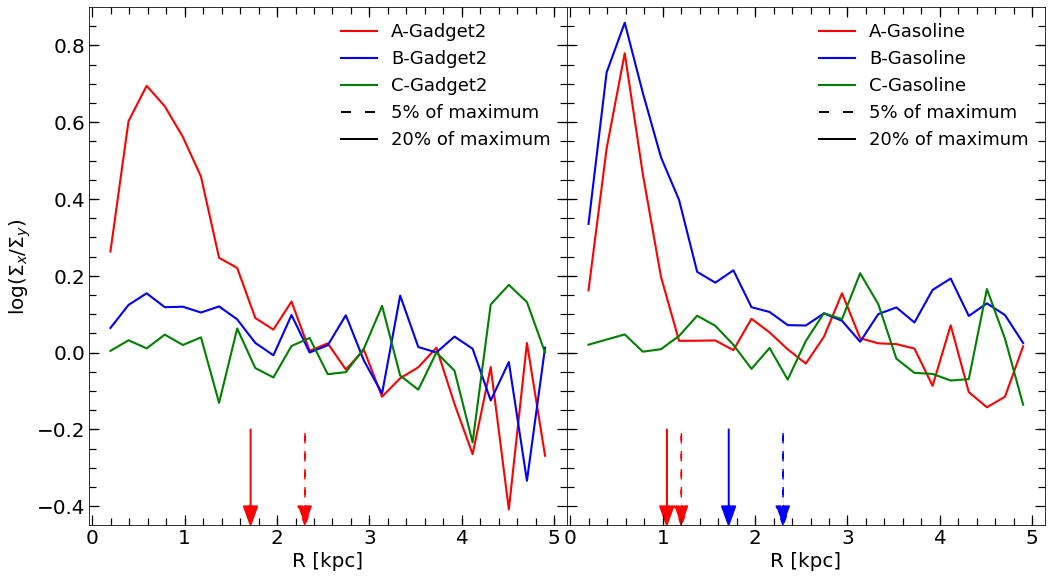

In [127]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D  

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16,8),sharey=True)
fig.subplots_adjust(bottom=0.06, left =0.1, right = 0.93, top = 0.96, wspace=0., hspace= 0.)

ax[0].plot(difR_M31GD, diff_M31GD, '-r', lw = 2.1, label='A-Gadget2')
ax[0].plot(difR_MWGD, diff_MWGD, '-b', lw = 2.1, label='B-Gadget2')
ax[0].plot(difR_M33GD, diff_M33GD, '-g', lw = 2.1, label='C-Gadget2')
# ax[0].axvline(x=lbar6_M31GD,ls='-',ymin=0., ymax=0.2,color='r', lw=1.5)
ax[0].arrow(x=lbar6_M31GD,y=-0.2,dx=0,dy=-0.25,color='r', lw=1.5,
             head_length=0.05,head_width=0.15,length_includes_head=True)
ax[0].arrow(x=lbar4_M31GD,y=-0.2,dx=0,dy=-0.25,color='r', lw=1.5, ls=(0,(5,7)),
            head_length=0.05,head_width=0.15,length_includes_head=True)
# ax[0].axvline(x=lbar4_M31GD,ls='--',ymin=0., ymax=0.2, color='r', lw=1.5, dashes=(10, 5))
ax[0].minorticks_on()
ax[0].set_ylim(-0.45,0.9)
ax[0].tick_params( labelsize=20)
ax[0].tick_params('both', length=7, width=1.2,which='minor', direction='in', right=True,top=True)
ax[0].tick_params('both', length=10, width=1.2,which='major', direction='in', right=True,top=True)
ax[0].set_ylabel('log($\Sigma_x / \Sigma_y$)',fontsize=20)
ax[0].set_xlabel('R [kpc]',fontsize=20)
ax[0].add_line(Line2D((0,0),(0,0), color='k',  ls=(0,(5,7)), lw=2,label='5% of maximum'))
ax[0].add_line(Line2D((0,0),(0,0), color='k',  ls='-', lw=2, label= '20% of maximum'))
ax[0].legend(fontsize=18,frameon=False)

ax[1].plot(difR_M31GS, diff_M31GS, '-r', lw = 2.1, label='A-Gasoline')
ax[1].plot(difR_MWGS, diff_MWGS, '-b', lw = 2.1, label='B-Gasoline')
ax[1].plot(difR_M33GS, diff_M33GS, '-g', lw = 2.1, label='C-Gasoline')
ax[1].arrow(x=lbar6_M31GS,y=-0.2,dx=0,dy=-0.25,color='r', lw=1.5,
             head_length=0.05,head_width=0.15,length_includes_head=True)
ax[1].arrow(x=lbar4_M31GS,y=-0.2,dx=0,dy=-0.25,color='r', lw=1.5, ls=(0,(5,7)),
            head_length=0.05,head_width=0.15,length_includes_head=True)
ax[1].arrow(x=lbar6_M31GD,y=-0.2,dx=0,dy=-0.25,color='b', lw=1.5,
             head_length=0.05,head_width=0.15,length_includes_head=True)
ax[1].arrow(x=lbar4_M31GD,y=-0.2,dx=0,dy=-0.25,color='b', lw=1.5, ls=(0,(5,7)),
            head_length=0.05,head_width=0.15,length_includes_head=True)
ax[1].minorticks_on()
ax[1].tick_params( labelsize=20)
ax[1].tick_params('both', length=7, width=1.2,which='minor', direction='in', right=True,top=True)
ax[1].tick_params('both', length=10, width=1.2,which='major', direction='in', right=True,top=True)
# ax[1].set_ylabel('log($\Sigma_x / \Sigma_y$)',fontsize=20)
ax[1].set_xlabel('R [kpc]',fontsize=20)
ax[1].add_line(Line2D((0,0),(0,0), color='k',  linestyle=(0,(5,7)), lw=2,label='5% of maximum'))
ax[1].add_line(Line2D((0,0),(0,0), color='k',  linestyle='-', lw=2, label= '20% of maximum'))
ax[1].legend(fontsize=18,frameon=False)

path ='/home/omarioni/Barras_GdGs/Barras_Gd/_imagenes/'
fig.savefig('diff_profile.pdf', dpi = 100, xxbox_inches='tight')
plt.show()

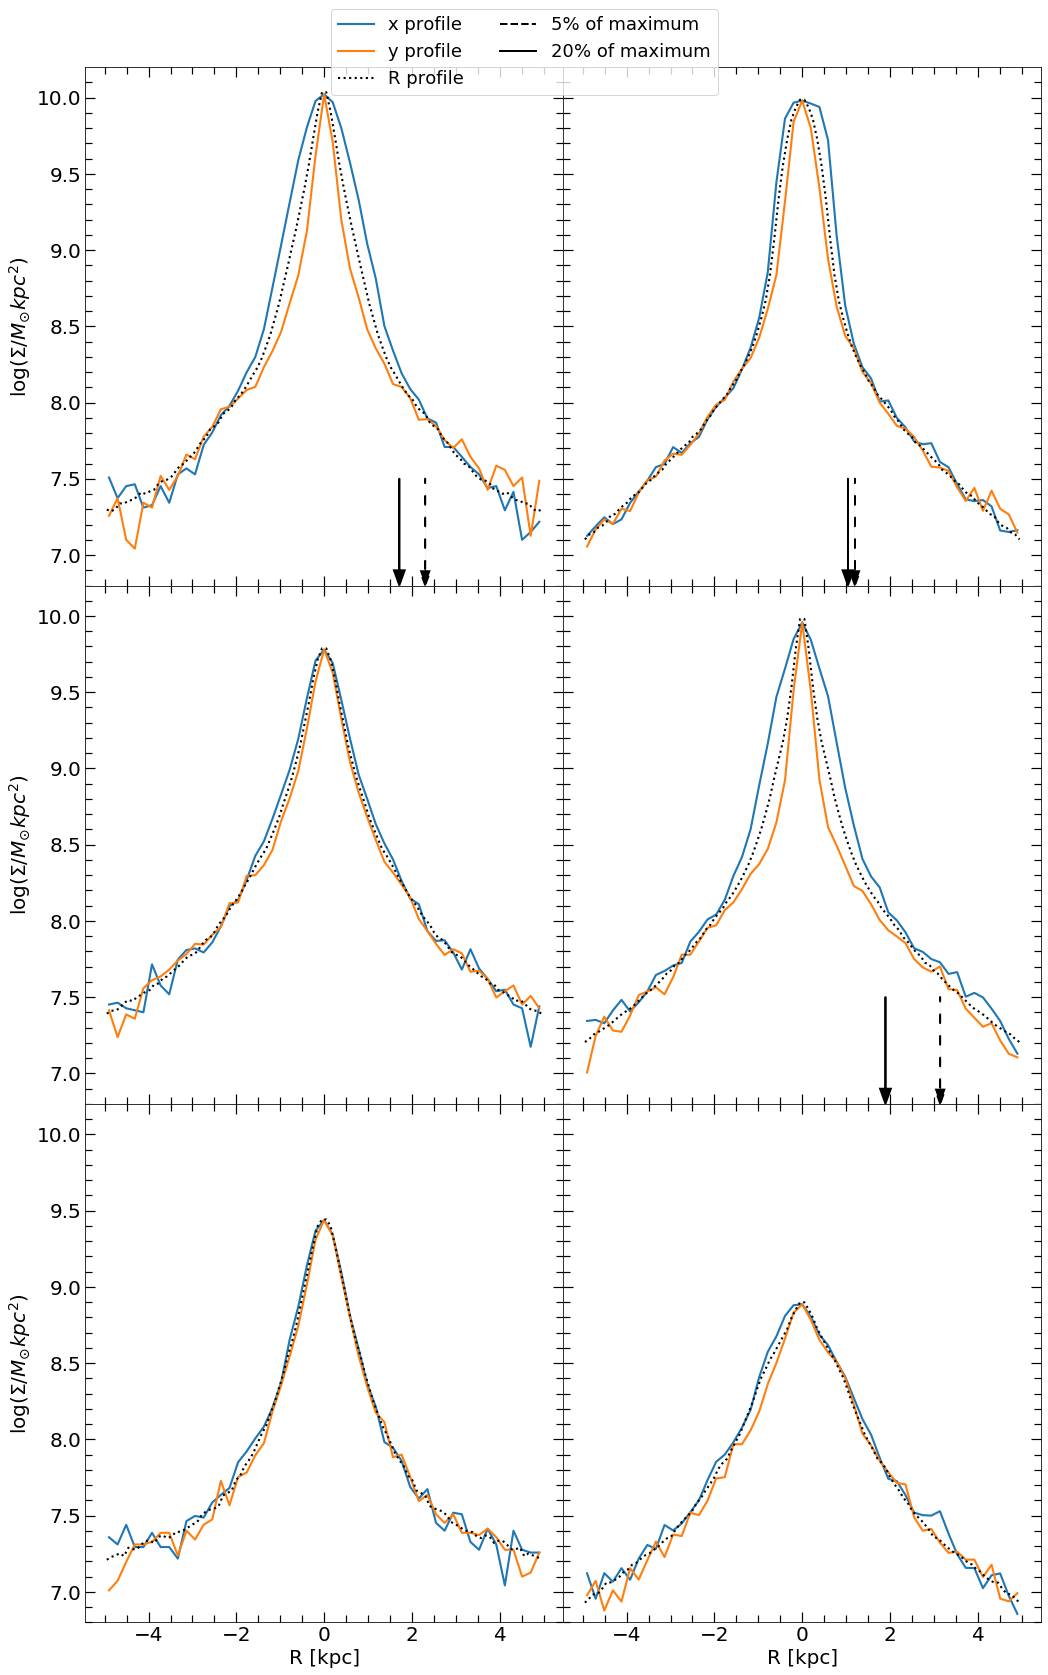

In [134]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D  

fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(16,24),sharey=True,sharex=True)
fig.subplots_adjust(bottom=0.06, left =0.1, right = 0.93, top = 0.96, wspace=0., hspace= 0.)

ax[0,0].plot(medx_M31GD, np.log10(sigx_M31GD), '-', color='tab:blue', lw = 2.1, label='x profile')
ax[0,0].plot(medy_M31GD, np.log10(sigy_M31GD), '-',color='tab:orange', lw = 2.1, label='y profile')
ax[0,0].plot(R_M31GD, np.log10(Rp_M31GD), ':k', lw = 2.1, label='R profile')
ax[0,0].arrow(x=lbar6_M31GD,y=7.5,dx=0,dy=-0.7,color='k', lw=1.8,
             head_length=0.1,head_width=0.25,length_includes_head=True)
ax[0,0].arrow(x=lbar4_M31GD,y=7.5,dx=0,dy=-0.7,color='k', lw=1.8, ls=(0,(5,7)),
            head_length=0.1,head_width=0.25,length_includes_head=True)
ax[0,0].set_ylim(6.8,10.2)
ax[0,0].minorticks_on()
ax[0,0].tick_params( labelsize=20)
ax[0,0].tick_params('both', length=7, width=1.2,which='minor', direction='in', right=True,top=True)
ax[0,0].tick_params('both', length=10, width=1.2,which='major', direction='in', right=True,top=True)
ax[0,0].set_ylabel('log($\Sigma$/$M_{\odot}kpc^2$)',fontsize=20)
ax[0,0].set_xlabel('R [kpc]',fontsize=20)
ax[0,0].add_line(Line2D((0,0),(0,0), color='k',  linestyle='--', lw=2,label='5% of maximum'))
ax[0,0].add_line(Line2D((0,0),(0,0), color='k',  linestyle='-', lw=2, label= '20% of maximum'))
fig.legend(fontsize=18, loc='upper center', ncol=2)

ax[1,0].plot(medx_MWGD, np.log10(sigx_MWGD), '-', color='tab:blue', lw = 2.1)
ax[1,0].plot(medy_MWGD, np.log10(sigy_MWGD), '-',color='tab:orange', lw = 2.1)
ax[1,0].plot(R_MWGD, np.log10(Rp_MWGD), ':k', lw = 2.1)
ax[1,0].minorticks_on()
ax[1,0].tick_params( labelsize=20)
ax[1,0].tick_params('both', length=7, width=1.2,which='minor', direction='in', right=True,top=True)
ax[1,0].tick_params('both', length=10, width=1.2,which='major', direction='in', right=True,top=True)
ax[1,0].set_xlabel('R [kpc]',fontsize=20)
ax[1,0].set_ylabel('log($\Sigma$/$M_{\odot}kpc^2$)',fontsize=20)

ax[2,0].plot(medx_M33GD, np.log10(sigx_M33GD), '-', color='tab:blue', lw = 2.1)
ax[2,0].plot(medy_M33GD, np.log10(sigy_M33GD), '-',color='tab:orange', lw = 2.1)
ax[2,0].plot(R_M33GD, np.log10(Rp_M33GD), ':k', lw = 2.1)
ax[2,0].minorticks_on()
ax[2,0].tick_params( labelsize=20)
ax[2,0].tick_params('both', length=7, width=1.2,which='minor', direction='in', right=True,top=True)
ax[2,0].tick_params('both', length=10, width=1.2,which='major', direction='in', right=True,top=True)
ax[2,0].set_xlabel('R [kpc]',fontsize=20)
ax[2,0].set_ylabel('log($\Sigma$/$M_{\odot}kpc^2$)',fontsize=20)

ax[0,1].plot(medx_M31GS, np.log10(sigx_M31GS), '-', color='tab:blue', lw = 2.1, label='x profile')
ax[0,1].plot(medy_M31GS, np.log10(sigy_M31GS), '-',color='tab:orange', lw = 2.1, label='y profile')
ax[0,1].plot(R_M31GS, np.log10(Rp_M31GS), ':k', lw = 2.1, label='R profile')
ax[0,1].arrow(x=lbar6_M31GS,y=7.5,dx=0,dy=-0.7,color='k', lw=1.8,
             head_length=0.1,head_width=0.25,length_includes_head=True)
ax[0,1].arrow(x=lbar4_M31GS,y=7.5,dx=0,dy=-0.7,color='k', lw=1.8, ls=(0,(5,7)),
            head_length=0.1,head_width=0.25,length_includes_head=True)
ax[0,1].minorticks_on()
ax[0,1].tick_params( labelsize=20)
ax[0,1].tick_params('both', length=7, width=1.2,which='minor', direction='in', right=True,top=True)
ax[0,1].tick_params('both', length=10, width=1.2,which='major', direction='in', right=True,top=True)
ax[0,1].set_xlabel('R [kpc]',fontsize=20)

ax[1,1].plot(medx_MWGS, np.log10(sigx_MWGS), '-', color='tab:blue', lw = 2.1)
ax[1,1].plot(medy_MWGS, np.log10(sigy_MWGS), '-',color='tab:orange', lw = 2.1)
ax[1,1].plot(R_MWGS, np.log10(Rp_MWGS), ':k', lw = 2.1)
ax[1,1].arrow(x=lbar6_MWGS,y=7.5,dx=0,dy=-0.7,color='k', lw=1.8,
             head_length=0.1,head_width=0.25,length_includes_head=True)
ax[1,1].arrow(x=lbar4_MWGS,y=7.5,dx=0,dy=-0.7,color='k', lw=1.8, ls=(0,(5,7)),
            head_length=0.1,head_width=0.25,length_includes_head=True)
ax[1,1].minorticks_on()
ax[1,1].tick_params( labelsize=20)
ax[1,1].tick_params('both', length=7, width=1.2,which='minor', direction='in', right=True,top=True)
ax[1,1].tick_params('both', length=10, width=1.2,which='major', direction='in', right=True,top=True)
ax[1,1].set_xlabel('R [kpc]',fontsize=20)

ax[2,1].plot(medx_M33GS, np.log10(sigx_M33GS), '-', color='tab:blue', lw = 2.1)
ax[2,1].plot(medy_M33GS, np.log10(sigy_M33GS), '-',color='tab:orange', lw = 2.1)
ax[2,1].plot(R_M33GS, np.log10(Rp_M33GS), ':k', lw = 2.1)
ax[2,1].minorticks_on()
ax[2,1].tick_params( labelsize=20)
ax[2,1].tick_params('both', length=7, width=1.2,which='minor', direction='in', right=True,top=True)
ax[2,1].tick_params('both', length=10, width=1.2,which='major', direction='in', right=True,top=True)
ax[2,1].set_xlabel('R [kpc]',fontsize=20)


path ='/home/omarioni/Barras_GdGs/Barras_Gd/_imagenes/'
fig.savefig('XY_profile.pdf', dpi = 100, xxbox_inches='tight')
plt.show()